# Dependencies

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import deque, namedtuple
from itertools import count

import random
import time

In [ ]:
local_runtime = True

In [ ]:
if local_runtime:
    # local device
    path = 'C:\\Users\\orvai\\DataspellProjects\\ML_final_project\\Models\\'
else:
    # drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path = '/content/gdrive/My Drive/RL Project/Models/'

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
torch.backends.cudnn.benchmark = True

In [ ]:
device

device(type='cuda', index=0)

# Env

In [ ]:
class Env2048:
	def __init__(self):
		self.grid = np.zeros((4, 4), dtype=int)
		self.add_tile()
		self.add_tile()
		self._score = 0

	def reset(self):
		self.__init__()
		return self.grid

	def copy(self):
		tmp = Env2048()
		tmp.grid = self.grid.copy()
		tmp.score = self._score
		return tmp

	def add_tile(self):
		i, j = (self.grid == 0).nonzero()
		assert (len(i)) != 0
		rnd = np.random.choice(len(i))
		self.grid[i[rnd], j[rnd]] = np.random.choice([1, 2], p=[0.9, 0.1])

	def is_done(self):
		for i in range(self.grid.shape[0]):
			for j in range(self.grid.shape[1]):
				if self.grid[i][j] == 0 or \
						i != 0 and self.grid[i - 1][j] == self.grid[i][j] or \
						j != 0 and self.grid[i][j - 1] == self.grid[i][j]:
					return False
		return True

	def step(self, action):
		rotated_board = np.rot90(self.grid, action)
		next_state = np.zeros((4, 4), dtype=int)

		for col_idx in range(4):
			col = rotated_board[col_idx, :]
			result = np.zeros(4, dtype=col.dtype)
			j, prev = 0, None
			for i in range(4):
				if col[i] != 0:
					if prev is None:
						prev = col[i]
					elif prev == col[i]:
						result[j] = col[i] + 1
						self._score += 1 << result[j]
						j += 1
						prev = None
					else:
						result[j] = prev
						j += 1
						prev = col[i]
			if prev is not None:
				result[j] = prev
			next_state[col_idx] = result

		next_state = np.rot90(next_state, -action)
		if not (next_state == self.grid).all():
			self.grid = next_state
			self.add_tile()

		return self.state(), self.empty_tiles(), self.is_done()

	def score(self):
		return self._score

	def state(self):
		return self.grid

	def max_tile(self):
		return 1 << self.grid.max()

	def _can_perform(self, action):
		tmp = np.rot90(self.state(), action)
		for row in range(4):
			has_empty = False
			for col in range(4):
				has_empty |= tmp[row, col] == 0
				if tmp[row, col] != 0 and has_empty:
					return True
				if (tmp[row, col] != 0 and col > 0 and
						tmp[row, col] == tmp[row, col - 1]):
					return True
		return False

	def possible_actions(self):
		res = []
		for a in range(4):
			if self._can_perform(a):
				res.append(a)
		return res

	def empty_tiles(self):
		count = 0
		for i in range(4):
			for j in range(4):
				count += (self.grid[i][j] == 0)
		return count

	def render(self):
		for i in range(4):
			for j in range(4):
				print((1 << self.grid[i][j] if self.grid[i][j] != 0 else ""), end="\t")
			print()

# Model

In [ ]:
Transition = namedtuple('Transition',
                        ('state', 'next_state', 'action', 'reward', 'done'))

In [ ]:
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        
        self.conv_a = nn.Conv2d(16, 128, kernel_size=(1,2))
        self.conv_b = nn.Conv2d(16, 128, kernel_size=(2,1))

        self.conv_aa = nn.Conv2d(128, 128, kernel_size=(1,2))
        self.conv_ab = nn.Conv2d(128, 128, kernel_size=(2,1))

        self.conv_ba = nn.Conv2d(128, 128, kernel_size=(1,2))
        self.conv_bb = nn.Conv2d(128, 128, kernel_size=(2,1))
        
        self.fc = nn.Sequential(
            nn.Linear(2*4*128*2+3*3*128*2+4*3*128*2, 256),
            nn.ReLU(),
            nn.Linear(256, 4)
        )

    def forward(self, x):
        x = x.to(device)
        x_a = F.relu(self.conv_a(x))
        x_b = F.relu(self.conv_b(x))
        
        x_aa = F.relu(self.conv_aa(x_a))
        x_ab = F.relu(self.conv_ab(x_a))
        
        x_ba = F.relu(self.conv_ba(x_b))
        x_bb = F.relu(self.conv_bb(x_b))
        
        sh_a = x_a.shape
        sh_aa = x_aa.shape
        sh_ab = x_ab.shape
        sh_b = x_b.shape
        sh_ba = x_ba.shape
        sh_bb = x_bb.shape
        
        x_a = x_a.view(sh_a[0],sh_a[1]*sh_a[2]*sh_a[3])
        x_aa = x_aa.view(sh_aa[0],sh_aa[1]*sh_aa[2]*sh_aa[3])
        x_ab = x_ab.view(sh_ab[0],sh_ab[1]*sh_ab[2]*sh_ab[3])
        x_b = x_b.view(sh_b[0],sh_b[1]*sh_b[2]*sh_b[3])
        x_ba = x_ba.view(sh_ba[0],sh_ba[1]*sh_ba[2]*sh_ba[3])
        x_bb = x_bb.view(sh_bb[0],sh_bb[1]*sh_bb[2]*sh_bb[3])
        
        concat = torch.cat((x_a,x_b,x_aa,x_ab,x_ba,x_bb),dim=1)
        
        output = self.fc(concat)
        
        return output

In [ ]:
from torchsummary import summary
summary(DQN().to(device), (16, 4, 4))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 128, 4, 3]           4,224
            Conv2d-2            [-1, 128, 3, 4]           4,224
            Conv2d-3            [-1, 128, 4, 2]          32,896
            Conv2d-4            [-1, 128, 3, 3]          32,896
            Conv2d-5            [-1, 128, 3, 3]          32,896
            Conv2d-6            [-1, 128, 2, 4]          32,896
            Linear-7                  [-1, 256]       1,900,800
              ReLU-8                  [-1, 256]               0
            Linear-9                    [-1, 4]           1,028
Total params: 2,041,860
Trainable params: 2,041,860
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 7.79
Estimated Total Size (MB): 7.85
---------------------------------------

# Train

## Utils

In [ ]:
GAMMA = 0.99 
EXPLORE = 10000
INITIAL_EPSILON = 0.1
FINAL_EPSILON = 0.0001
BUFFER_SIZE = 50000
BATCH = 16
UPDATE_RATE = 4

In [ ]:
policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())

<All keys matched successfully>

In [ ]:
memory = ReplayMemory(BUFFER_SIZE)
optimizer = torch.optim.Adam(policy_net.parameters(), lr=1e-4)
steps_done = 0

In [ ]:
 epsilon = INITIAL_EPSILON

In [ ]:
episode_durations = []
scores = []
max_tiles = []

In [ ]:
def one_hot_encode(state):
    result = np.zeros((1, 16, 4, 4), dtype=np.float32)
    for i in range(4):
        for j in range(4):
            result[0][state[i][j]][i][j] = 1.0
    return result

In [ ]:
def select_action(state, possible_actions, train=True):
    global epsilon
    state = torch.from_numpy(np.flip(state, axis=0).copy()).to(device)
    if random.random() < epsilon and train:
        return np.random.choice(possible_actions)
    for action in policy_net(state).argsort()[0].cpu().numpy()[::-1]:
        if action in possible_actions:
            return action
    raise ValueError()

## Train Functions

In [ ]:
def optimize_model():
    global steps_done, epsilon
    if len(memory) < 128:
        return
    steps_done += 1
    if steps_done % UPDATE_RATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

    batch_state, batch_next_state, batch_action, batch_reward, batch_done = zip(*memory.sample(BATCH))
	
    batch_state = torch.FloatTensor(np.array(batch_state)).squeeze(1).to(device)
    batch_next_state = torch.FloatTensor(np.array(batch_next_state)).squeeze(1).to(device)
    batch_action = torch.Tensor(batch_action).unsqueeze(1).to(device)
    batch_reward = torch.Tensor(batch_reward).unsqueeze(1).to(device)
    batch_done = torch.FloatTensor(batch_done).unsqueeze(1).to(device)
 
    with torch.no_grad():
        next_q_vals = target_net(batch_next_state)
        y = batch_reward + (1 - batch_done) * GAMMA * torch.max(next_q_vals, dim=1, keepdim=True)[0]
    
    loss = F.mse_loss(policy_net(batch_state).gather(1, batch_action.long()), y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epsilon > FINAL_EPSILON:
        epsilon -= (INITIAL_EPSILON - FINAL_EPSILON) / EXPLORE

In [ ]:
def train(env: Env2048, episodes=3000, save_rate=100, print_rate=100):
    global steps_done, epsilon
    start_time = time.time()
    for episode in range(episodes):
        state = one_hot_encode(env.reset())
        for t in count():
            action = select_action(state, env.possible_actions())
            next_state, reward, done = env.step(action)
            next_state = one_hot_encode(next_state)

            memory.push(state, next_state, torch.FloatTensor([[action]]).to(device), torch.FloatTensor([[reward]]).to(device), torch.FloatTensor([[done]]).to(device))
            optimize_model()

            state = next_state
            if done:
                episode_durations.append(t + 1)
                scores.append(env.score())
                max_tiles.append(env.max_tile())
                break
        
        if episode % save_rate == 0:
            torch.save(policy_net.state_dict(), path + 'policy_net.pth')
            torch.save(target_net.state_dict(), path + 'target_net.pth')
        
        if episode % print_rate == 0:
            env.render()
            print(f'episode {episode} | score {scores[-1]} | max {max_tiles[-1]} | steps {episode_durations[-1]} | time {time.time()-start_time}')
    print("Training Completed.")

## Train Agent

In [ ]:
env = Env2048()

In [ ]:
train(env)

4	2	8	16	
2	4	16	32	
4	16	256	2	
8	64	2	8	
episode 0 | score 2364 | max 256 | steps 200 | time 1.3449816703796387
16	2	4	32	
8	64	256	4	
4	8	64	128	
2	4	32	2	
episode 100 | score 3444 | max 256 | steps 286 | time 267.9054448604584
2	4	8	32	
8	16	64	512	
4	32	2	128	
2	4	8	32	
episode 200 | score 5480 | max 512 | steps 378 | time 652.9211304187775
2	16	8	64	
4	8	16	128	
2	4	64	512	
4	8	32	64	
episode 300 | score 5912 | max 512 | steps 417 | time 1137.7455298900604
2	4	8	64	
8	16	32	128	
4	64	512	2	
2	8	32	64	
episode 400 | score 6032 | max 512 | steps 435 | time 1735.8842027187347
2	8	16	32	
4	16	32	128	
8	4	64	256	
4	2	16	512	
episode 500 | score 7240 | max 512 | steps 505 | time 2402.364599943161
4	2	4	64	
8	32	64	256	
4	2	16	512	
2	4	2	64	
episode 600 | score 6884 | max 512 | steps 475 | time 3076.522155046463
2	8	32	64	
4	16	64	1024	
8	64	128	256	
4	2	32	128	
episode 700 | score 13528 | max 1024 | steps 836 | time 3807.831784248352
2	4	32	128	
8	16	128	512	
16	4	32	64	
4	2	16	32	
epi

In [ ]:
torch.save(policy_net.state_dict(), path + 'policy_net.pth')
torch.save(target_net.state_dict(), path + 'target_net.pth')

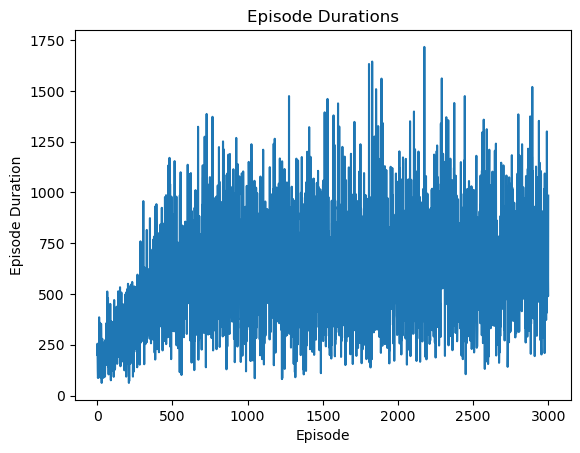

In [ ]:
plt.plot(episode_durations, label='test')
plt.xlabel('Episode')
plt.ylabel('Episode Duration')
plt.title('Episode Durations')
plt.show()

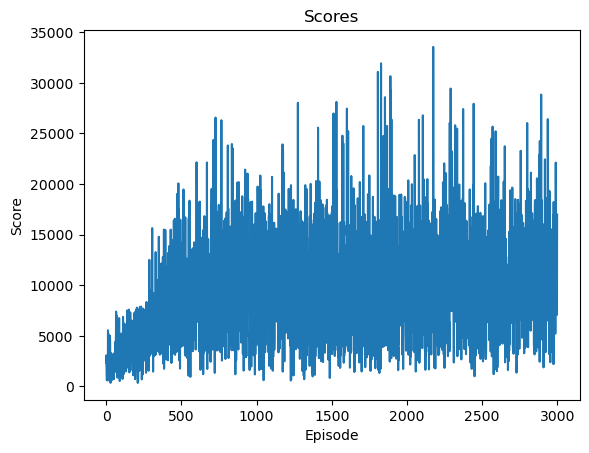

In [ ]:
plt.plot(scores, label='test')
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('Scores')
plt.show()

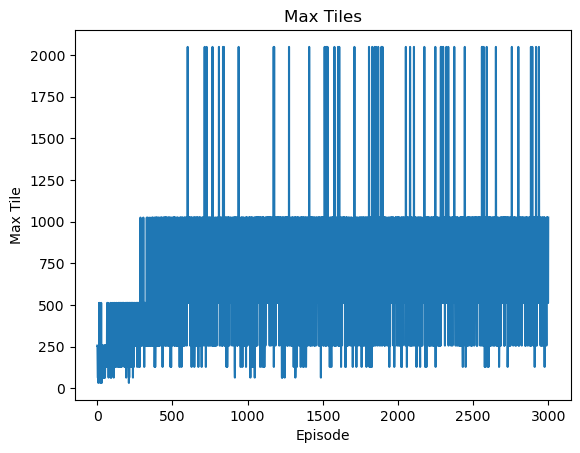

In [ ]:
plt.plot(max_tiles, label='test')
plt.xlabel('Episode')
plt.ylabel('Max Tile')
plt.title('Max Tiles')
plt.show()

# Test

## Web Environment

In [ ]:
from selenium.common.exceptions import StaleElementReferenceException
from webdriver_manager.chrome import ChromeDriverManager
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service

In [ ]:
class WebEnv2048:
	def __init__(self):
		self.url = 'http://gabrielecirulli.github.io/2048/'
		self.driver = webdriver.Chrome(ChromeDriverManager().install())
		self.driver.get(self.url)
		self.body = self.driver.find_element_by_tag_name('body')
		self.moves = {
			0: Keys.ARROW_LEFT,
			1: Keys.ARROW_UP,
			2: Keys.ARROW_RIGHT,
			3: Keys.ARROW_DOWN
		}
	
	# TODO: reset w/o losing?
	def _parse_class_name(self, s: str):
		fields = s.replace('-', ' ').split(' ')
		return int(fields[6]), int(fields[5]), int(fields[2]), None if len(fields) < 9 else fields[8]
	
	def reset(self):
		self.driver.find_element_by_class_name('retry-button').click()
	
	def state(self):
		try:
			grid = np.zeros((4, 4), dtype=int)
			tiles = self.driver.find_elements_by_class_name('tile')
			tiles_data = [self._parse_class_name(t.get_attribute('class')) for t in tiles]
			
			for row, col, val, flag in tiles_data:
				if flag != 'merged':
					grid[row - 1][col - 1] += val
			for i in range(4):
				for j in range(4):
					if grid[i][j] != 0:
						grid[i][j] = math.log(grid[i][j], 2)
			return grid
		except StaleElementReferenceException:
			return self.state()

	def step(self, action):
		old_score = self.score()
		old_grid = self.state()
		self.body.send_keys(self.moves[action])
		if (old_grid == self.state()).all():
			return -100
		return self.score() - old_score
	
	def is_done(self):
		grid = self.state()
		for i in range(grid.shape[0]):
			for j in range(grid.shape[1]):
				if grid[i][j] == 0 or \
						i != 0 and grid[i - 1][j] == grid[i][j] or \
						j != 0 and grid[i][j - 1] == grid[i][j]:
					return False
		return True
	
	def max_tile(self):
		return 1 << self.state().max()
	
	def score(self):
		s = self.body.find_element_by_xpath('/html/body/div[1]/div[1]/div/div[1]').text
		return int(s.split('\n')[0])
		
	def _can_perform(self, action):
		tmp = np.rot90(self.state(), action)
		for row in range(4):
			has_empty = False
			for col in range(4):
				has_empty |= tmp[row, col] == 0
				if tmp[row, col] != 0 and has_empty:
					return True
				if (tmp[row, col] != 0 and col > 0 and
						tmp[row, col] == tmp[row, col - 1]):
					return True
		return False
	
	def possible_actions(self):
		res = []
		for a in range(4):
			if self._can_perform(a):
				res.append(a)
		return res

## Test Functions

In [ ]:
def single_game(env):
    global epsilon
    tmp = epsilon
    epsilon = FINAL_EPSILON
    for t in count():
        env.step(select_action(one_hot_encode(env.state()), env.possible_actions()))
        if env.is_done():
            return t, env.score(), env.max_tile()
    epsilon = tmp

In [ ]:
def test(env, episodes=1000):
    episode_durations_test = []
    scores_test = []
    max_tiles_test = []
    for episode in range(episodes):
        t, score, max_tile = single_game(env)
        episode_durations_test.append(t + 1)
        scores_test.append(score)
        max_tiles_test.append(max_tile)
        env.reset()
    return episode_durations_test, scores_test, max_tiles_test

## Test Agent

In [ ]:
# load from path (local / drive)
policy_net.load_state_dict(torch.load(path + 'policy_net.pth'))

<All keys matched successfully>

### j

In [ ]:
test_env = Env2048()

In [ ]:
episode_durations_test, scores_test, max_tiles_test = test(test_env, episodes=10)

In [ ]:
plt.plot(episode_durations_test, label='test')
plt.xlabel('Episode')
plt.ylabel('Episode Duration')
plt.title('Episode Durations')
plt.show()

In [ ]:
plt.plot(scores_test, label='test')
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('Scores')
plt.show()

In [ ]:
plt.plot(max_tiles_test, label='test')
plt.xlabel('Episode')
plt.ylabel('Max Tile')
plt.title('Max Tiles')
plt.show()

### i

In [ ]:
web_env = WebEnv2048()

[WDM] - Downloading: 100%|████████████████████████████████████████████████████████| 6.79M/6.79M [00:00<00:00, 7.73MB/s]


In [ ]:
single_game(web_env)